# Introduction

## Problem Statement

<img src="../images/selling_process.jpg" alt="drawing" width="900"/>

Selling a car can be a stressful situation for car owners. Not knowing the market price of their vehicles leave them comparing quotes between dealers and figuring out to sell the car directly. Not knowing the price of their vehicle can leave them vulnerable to being "under-quoted" by car agencies.

Having the knowledge of the market price of their vehicles would empower car-owners to be able to make informed decisions and review the trade off between selling to car agencies or selling directly. Knowing the difference in price would allow the car owners to evaluate the effort and time in dollars. That is what I intend to achieve with this project.

## Background of Data

<img src="../images/sgcarmart_webpage.jpg" alt="drawing" width="900"/>

For this project, the data for the cars listing were scraped from [SG Car Mart](SGCarMart.com). The data was scraped on the 17th December 2020. The below table is the dictionary of the data that I will be working with. The scraping of data were done in a separate notebook as they are date sensitive. I have also scraped data on the 22nd January 2021 to validate my model on more recent listings in the website.

|**Feature**|**Type**|**Description**|
|---|---|---|
|model|object|Make & Model of the car|
|price|object|Price of Cars Listed|
|mileage|integer|The total distance the car has travelled|
|road_tax|integer|The amount of tax payable for a vehicle to use the roads in a year|
|coe|integer|The price of COE (latest) that was registered to the vehicle : note that COE expires every 10 years and subject to renewal or termination|
|eng_cap|integer|The engine capacity of a car|
|curb_weight|integer|The weight of the vehicle|
|manufactured|integer|The year the car was manufactured|
|transmission|object|Gear transmission of the car: Automatic or Manual|
|omv|integer|The machine price of the car (coe not included)|
|power|integer|Engine power|
|num_owners|integer|Toal number of owners (past & present): [1: 1 owner, 2: 2 owners, 3: 3 owners, 4: 4 owners, 5: 5 owners, 6: 6 owners, 7: 7 or more owners]|
|type|object|The vehicle types: [Hatchback, MPV, SUV, Luxury Sedan, Mid-Size Sedan, Sports Car, Stationwagon]|
|category|object|The categories of cars listing: [Premium Ad Car, COE Car, PARF Car, Almost New Car, Direct Owner Sale, STA Evaluated Car, sgCarMart Warranty Cars, Consignment Car, Rare & Exotic, Low Mileage Car]|

# Data Cleaning

In [1]:
#import packages
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

In [2]:
#converting csv into dataframe
cars = pd.read_csv('../data/cars_info.csv')

In [3]:
#checking the dataframe
cars.head()

,Unnamed: 0,model,link,price,depreciation,reg_date,mileage,road_tax,coe,eng_cap,curb_weight,manufactured,transmission,omv,power,num_owners,type,category
0,0,BMW 1 Series 116d,info.php?ID=950050&DL=2913,"$77,800","$10,770 /yrVie...",26-Jul-2017(6yrs 7mths 9days COE left) ...,"76,600...","\t$1,082 /yr","$44,002","1,496 cc","1,350 kg ...",2017,Auto,"$25,894",85.0 kW (113 bhp),1,Hatchback,Category\nPARF Car
1,1,Toyota Wish 1.8A (COE till 11/2022),info.php?ID=928124&DL=1220,"$15,500","$8,200 /yr ...",07-Nov-2007(1yr 10mths 21days COE left) ...,"172,00...","\t$1,361 /yr","$25,084","1,794 cc","1,300 kg ...",2007,Auto,"$16,527",97.0 kW (130 bhp),3,MPV,Category\nCOE Car
2,2,Audi TT Roadster 2.0A TFSI S-tronic (New 10-yr...,info.php?ID=944820&DL=3125,"$83,800","$8,380 /yr ...",23-Dec-2010(10yrs COE left) ...,N.A. ...,"\t$1,194 /yr",N.A.,"1,984 cc","1,315 kg ...",2009,Auto,"$54,102",147.0 kW (197 bhp),3,Sports Car,"Category\nCOE Car, Premium Ad Car"
3,3,BMW 5 Series 520i (New 10-yr COE),info.php?ID=941944&DL=1220,"$86,800","$8,680 /yr ...",31-Oct-2011(10yrs COE left) ...,"140,00...","\t$1,210 /yr",N.A.,"1,997 cc","1,610 kg ...",2011,Auto,"$45,036",135.0 kW (181 bhp),1,Luxury Sedan,Category\nCOE Car
4,4,Honda Civic Type R 2.0M (COE till 03/2029),info.php?ID=952605&DL=1000,N.A,N.A ...,02-Jun-2009(8yrs 3mths 15days COE left) ...,N.A. ...,"\t$1,452 /yr","$33,018","1,998 cc","1,270 kg ...",2008,Manual,"$34,597",165.0 kW (221 bhp),1,Sports Car,"Category\nCOE Car, Direct Owner Sale, Low Mile..."


We can see that there are unwanted columns in the dataframe. The `Unnamed: 0` column was due to the conversion of dataframe to csv in the previous notebook. `depreciation` column is derived from the sale price as it is calculated by:

$$ (Sale Price - PARF) / 12 $$

Since `depreciation` is not independent of `price`, our target variable, we will be dropping the column as well.

In [4]:
#dropping columns
cars.drop(columns=['depreciation','Unnamed: 0','link'],inplace=True)

## Dealing with Null Values

There were imperfections in the scraping portion of the data. As we can see from the image below, there exists a possibility that the data scraped might have some missing data. These are largely due to the car listed being sold. Since we cannot impute logically, as these are all car data, we will try and remove them and see if we have a large enough dataset to train our model.

<img src="../images/sgcarmart_sold.jpg" alt="drawing" width="900"/>


In [5]:
#checking for null values
cars.isnull().sum()

model           0
price           1
reg_date        1
mileage         1
road_tax        1
coe             1
eng_cap         1
curb_weight     1
manufactured    1
transmission    1
omv             1
power           1
num_owners      1
type            1
category        1
dtype: int64

In [6]:
#checking for the null
cars[cars['transmission'].isnull()]

,model,price,reg_date,mileage,road_tax,coe,eng_cap,curb_weight,manufactured,transmission,omv,power,num_owners,type,category
100,Expired ads,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#dropping null value
cars.drop(index=100,inplace=True)

In [8]:
#checking null once more
cars.isnull().sum()

model           0
price           0
reg_date        0
mileage         0
road_tax        0
coe             0
eng_cap         0
curb_weight     0
manufactured    0
transmission    0
omv             0
power           0
num_owners      0
type            0
category        0
dtype: int64

In [9]:
#checking cars without price
cars[cars['price'].str.contains('N.A')].index

Int64Index([   4,  148,  201,  353,  355,  368,  447,  526,  660,  667,
            ...
            4959, 4961, 4964, 4966, 4974, 4979, 4981, 4985, 4993, 4998],
           dtype='int64', length=429)

In [10]:
#dropping observations without price
cars.drop(index=cars[cars['price'].str.contains('N.A')].index,inplace=True)

In [11]:
#checking wrongly inputted curb_weight
cars[cars['curb_weight'].str.contains('N.A')].index

Int64Index([  56,  105,  262,  270,  285,  378,  381,  390,  394,  402,
            ...
            4308, 4454, 4661, 4807, 4836, 4838, 4841, 4842, 4844, 4925],
           dtype='int64', length=108)

In [12]:
#removing wrongly inputted curb_weight
cars.drop(index=cars[cars['curb_weight'].str.contains('N.A')].index,inplace=True)

In [13]:
#checking wrongly inputted eng_cap
cars[cars['eng_cap'].str.contains('N.A')].index

Int64Index([1444, 2322, 2950, 3894], dtype='int64')

In [14]:
#removing wrongly inputted eng_cap
cars.drop(index=cars[cars['eng_cap'].str.contains('N.A')].index,inplace=True)

In [15]:
#checking for missing coe
cars[cars['coe'].str.contains('N.A')].index

Int64Index([   2,    3,   12,   17,   30,   55,   69,   83,   88,  139,
            ...
            4893, 4900, 4927, 4935, 4942, 4947, 4967, 4968, 4980, 4997],
           dtype='int64', length=479)

In [16]:
#dropping the wrongly inputted coe
cars.drop(index=cars[cars['coe'].str.contains('N.A')].index,inplace=True)

In [17]:
#checking for missing reg_date
cars[cars['reg_date'].str.contains('N.A')].index

Int64Index([], dtype='int64')

In [18]:
#removing wrongly inputted reg_date
cars.drop(index=cars[cars['reg_date'].str.contains('N.A')].index,inplace=True)

In [19]:
#checking for missing power
cars[cars['power'].str.contains('N.A')].index

Int64Index([], dtype='int64')

In [20]:
#checking for missing omv
cars[cars['omv'].str.contains('N.A')].index

Int64Index([], dtype='int64')

In [21]:
#checking wrongly inputted mileage
cars[cars['mileage'].str.contains('N.A')].index

Int64Index([   7,   11,   31,   37,   47,   50,   54,   64,   71,   85,
            ...
            4921, 4928, 4929, 4949, 4955, 4956, 4963, 4969, 4983, 4990],
           dtype='int64', length=592)

In [22]:
#removing wrongly inputted observations
cars.drop(index=cars[cars['mileage'].str.contains('N.A')].index,inplace=True)

In [23]:
#checking for missing road_tax
cars[cars['road_tax'].str.contains('N.A')].index

Int64Index([538, 2491, 3205, 3654, 3676, 4940], dtype='int64')

In [24]:
#dropping the wrongly inputted road_tax
cars.drop(index=cars[cars['road_tax'].str.contains('N.A')].index,inplace=True)

## Dealing With Special Characters and Scraping Error

In [25]:
#checking the dataframe
cars.head(5)

,model,price,reg_date,mileage,road_tax,coe,eng_cap,curb_weight,manufactured,transmission,omv,power,num_owners,type,category
0,BMW 1 Series 116d,"$77,800",26-Jul-2017(6yrs 7mths 9days COE left) ...,"76,600...","\t$1,082 /yr","$44,002","1,496 cc","1,350 kg ...",2017,Auto,"$25,894",85.0 kW (113 bhp),1,Hatchback,Category\nPARF Car
1,Toyota Wish 1.8A (COE till 11/2022),"$15,500",07-Nov-2007(1yr 10mths 21days COE left) ...,"172,00...","\t$1,361 /yr","$25,084","1,794 cc","1,300 kg ...",2007,Auto,"$16,527",97.0 kW (130 bhp),3,MPV,Category\nCOE Car
5,Opel Astra 1.4A Turbo,"$59,800",30-Dec-2016(6yrs 13days COE left) ...,"43,000...",\t$626 /yr,"$51,109","1,399 cc","1,233 kg ...",2016,Auto,"$19,839",110.0 kW (147 bhp),2,Hatchback,Category\nPARF Car
6,Toyota Harrier 2.0A Premium,"$83,888",15-Apr-2016(5yrs 3mths 29days COE left) ...,"60,540...","\t$1,196 /yr","$50,089","1,986 cc","1,610 kg ...",2016,Auto,"$30,993",111.0 kW (148 bhp),1,SUV,"Category\nPARF Car, Premium Ad Car"
8,BMW 2 Series 216d Active Tourer,"$82,800",22-Aug-2017(6yrs 8mths 5days COE left) ...,"70,000...","\t$1,082 /yr","$46,778","1,496 cc","1,395 kg ...",2017,Auto,"$28,674",85.0 kW (113 bhp),1,Hatchback,Category\nPARF Car


We also notice that there are many special characters in the columns. Let's proceed to remove them.

In [26]:
#checking car types
cars['type'].unique()

array(['Hatchback', 'MPV', 'SUV', 'Luxury Sedan', 'Sports Car',
       'Mid-Sized Sedan', 'Stationwagon'], dtype=object)

In [27]:
#checking for wrongly inputted transmission column
cars['transmission'].unique()

array(['Auto', 'Manual'], dtype=object)

In [28]:
#removing wrongly scraped transmission data
cars = cars[cars['transmission'].str.contains('Manual') | cars['transmission'].str.contains('Auto')]

In [29]:
#removing special characters in price
cars['price'] = cars['price'].str.replace("$","")
cars['price'] = cars['price'].str.replace(",","")

<ipython-input-29-8c0819e483a2>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  cars['price'] = cars['price'].str.replace("$","")


In [30]:
#removing special characters in curb_weight
cars['curb_weight'] = cars['curb_weight'].str.replace(",","")
cars['curb_weight'] = cars.curb_weight.str.extract('(\d+)')

In [31]:
#removing special characters in eng_cap
cars['eng_cap'] = cars['eng_cap'].str.replace(",","")
cars['eng_cap'] = cars.eng_cap.str.extract('(\d+)')

In [32]:
#removing special characters in coe
cars['coe'] = cars['coe'].str.replace("$","")
cars['coe'] = cars['coe'].str.replace(",","")

<ipython-input-32-bcc8b4c3a4c5>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  cars['coe'] = cars['coe'].str.replace("$","")


Since the registration date has the coe balance in it, let's extract them and convert the years and months into COE in months feature.

In [33]:
#extracting years and months values from reg_date
cars['years'] = cars['reg_date'].str.findall('(\d+)yr').str[0]
cars['months'] = cars['reg_date'].str.findall('(\d+)mth').str[0]

In [34]:
#checking for values extracted for years and months
print(cars['years'].unique())
print(cars['months'].unique())

['6' '1' '5' '4' '8' '9' '3' '7' '2' nan '10']
['7' '10' nan '3' '8' '5' '11' '4' '6' '2' '9' '1']


In [35]:
cars[cars['years'].isnull()]

,model,price,reg_date,mileage,road_tax,coe,eng_cap,curb_weight,manufactured,transmission,omv,power,num_owners,type,category,years,months
101,BMW 7 Series 730Li Sunroof,54879,28-Oct-2011(10mths 11days COE left) ...,"139,00...","\t$2,382 /yr",75889,2996,1855,2011,Auto,"$72,702",190.0 kW (254 bhp),1,Luxury Sedan,Category\nPARF Car,NaN,10
130,Mercedes-Benz E-Class E250 CGI,38200,06-Jul-2011(6mths 19days COE left) ...,"128,00...",\t$974 /yr,56001,1796,1650,2011,Auto,"$52,909",150.0 kW (201 bhp),4,Luxury Sedan,"Category\nPARF Car, Direct Owner Sale",NaN,6
143,Mercedes-Benz S-Class S350L CGI,109000,10-Oct-2011(9mths 23days COE left) ...,"111,00...","\t$3,164 /yr",68811,3498,1975,2011,Auto,"$98,214",225.0 kW (301 bhp),2,Luxury Sedan,Category\nPARF Car,NaN,9
292,BMW 3 Series 320i M-Sport Sunroof,26800,14-Mar-2011(2mths 25days COE left) ...,"136,45...","\t$1,208 /yr",62010,1995,1390,2010,Auto,"$40,475",115.0 kW (154 bhp),3,Luxury Sedan,"Category\nPARF Car, Premium Ad Car",NaN,2
301,BMW 5 Series 523i Highline,38800,30-May-2011(5mths 13days COE left) ...,"137,51...","\t$1,796 /yr",57100,2497,1650,2011,Auto,"$49,316",150.0 kW (201 bhp),4,Luxury Sedan,Category\nPARF Car,NaN,5
305,Hyundai Avante 1.6A,10800,29-Apr-2011(4mths 12days COE left) ...,"138,33...",\t$738 /yr,43212,1591,1264,2010,Auto,"$10,385",89.7 kW (120 bhp),3,Mid-Sized Sedan,"Category\nPARF Car, Premium Ad Car",NaN,4
327,Toyota Estima 2.4A Welcab (COE till 06/2021),5500,29-Jul-2006(6mths 14days COE left) ...,"189,00...","\t$2,457 /yr",24240,2362,1850,2006,Auto,"$29,235",125.0 kW (167 bhp),More than 6,MPV,Category\nCOE Car,NaN,6
492,Toyota Camry 2.0A,23800,15-Sep-2011(8mths 29days COE left) ...,"126,70...","\t$1,210 /yr",72501,1998,1530,2011,Auto,"$22,432",108.0 kW (144 bhp),2,Luxury Sedan,Category\nPARF Car,NaN,8
546,Toyota Camry 2.0A,21800,29-Apr-2011(4mths 12days COE left) ...,"133,00...","\t$1,210 /yr",62010,1998,1530,2011,Auto,"$23,514",108.0 kW (144 bhp),3,Luxury Sedan,"Category\nPARF Car, Direct Owner Sale",NaN,4
596,BMW 5 Series 535i M-Sport Sunroof,58800,15-Dec-2011(11mths 28days COE left) ...,"119,00...","\t$2,362 /yr",78001,2979,1700,2011,Auto,"$65,662",225.0 kW (301 bhp),3,Luxury Sedan,"Category\nPARF Car, Direct Owner Sale",NaN,11


In [36]:
cars[cars['months'].isnull()]

,model,price,reg_date,mileage,road_tax,coe,eng_cap,curb_weight,manufactured,transmission,omv,power,num_owners,type,category,years,months
5,Opel Astra 1.4A Turbo,59800,30-Dec-2016(6yrs 13days COE left) ...,"43,000...",\t$626 /yr,51109,1399,1233,2016,Auto,"$19,839",110.0 kW (147 bhp),2,Hatchback,Category\nPARF Car,6,NaN
15,Toyota Camry Hybrid 2.5A G,103800,04-Jan-2019(8yrs 18days COE left) ...,"13,000...","\t$1,784 /yr",32000,2487,1570,2018,Auto,"$35,821",155.0 kW (207 bhp),1,Luxury Sedan,"Category\nPARF Car, Premium Ad Car, Low Mileag...",8,NaN
42,Mazda CX-5 2.5A Luxury Sunroof,81800,30-Dec-2016(6yrs 13days COE left) ...,"63,200...","\t$1,786 /yr",56340,2488,1568,2016,Auto,"$27,550",141.0 kW (189 bhp),1,SUV,"Category\nPARF Car, Premium Ad Car, STA Evalua...",6,NaN
45,Nissan Qashqai 1.2A DIG-T,63800,23-Dec-2016(6yrs 6days COE left) ...,"42,000...",\t$508 /yr,48000,1197,1285,2016,Auto,"$18,689",85.0 kW (113 bhp),1,SUV,"Category\nPARF Car, Premium Ad Car",6,NaN
48,Toyota Rush 1.5A (COE till 01/2022),9800,09-Jan-2007(1yr 23days COE left) ...,"192,00...",\t$955 /yr,25323,1495,1150,2006,Auto,"$15,753",80.0 kW (107 bhp),3,SUV,"Category\nCOE Car, Direct Owner Sale",1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4865,Mazda CX-3 2.0A Standard,76800,27-Dec-2018(8yrs 10days COE left) ...,"27,000...","\t$1,210 /yr",30959,1998,1290,2018,Auto,"$16,890",115.0 kW (154 bhp),1,SUV,Category\nPARF Car,8,NaN
4874,BMW 4 Series 430i Gran Coupe M-Sport,140000,03-Jan-2017(6yrs 17days COE left) ...,"48,000...","\t$1,210 /yr",46229,1998,1540,2016,Auto,"$47,372",185.0 kW (248 bhp),1,Luxury Sedan,"Category\nPARF Car, Premium Ad Car",6,NaN
4881,Mazda 3 HB 1.5A Sunroof,54800,31-Dec-2015(5yrs 14days COE left) ...,"72,441...",\t$682 /yr,54301,1496,1324,2015,Auto,"$18,265",88.0 kW (118 bhp),2,Hatchback,"Category\nPARF Car, Premium Ad Car",5,NaN
4914,Lexus ES250 Executive Sunroof,162800,23-Dec-2019(9yrs 6days COE left) ...,"19,750...","\t$1,784 /yr",36000,2487,1620,2019,Auto,"$40,126",152.0 kW (203 bhp),1,Luxury Sedan,"Category\nPARF Car, Almost New Car, Premium Ad...",9,NaN


We can see that there are missing months and years. Logically, we can assume them as 0.

In [37]:
#filling null values in years and months with 0
cars['years'].fillna(0,inplace=True)
cars['months'].fillna(0,inplace=True)

In [38]:
#converting data type into an integer
cars['years'] = cars['years'].astype(int)
cars['months'] = cars['months'].astype(int)

In [39]:
#transforming the years and months into balance COE in months
cars['coe_balance_in_months'] = cars['years']*12 + cars['months']
cars.drop(columns=['years','months'],inplace=True)

Since we do not need the `reg_date` anymore, let's also drop the column.

In [40]:
cars.drop(columns='reg_date',inplace=True)

In [41]:
#removing special characters in power
cars['power'] = cars['power'].str.replace(r"\(.*?\)","")
cars['power'] = cars.power.str.extract('(\d+)')

<ipython-input-41-01648d6e258e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  cars['power'] = cars['power'].str.replace(r"\(.*?\)","")


In [42]:
#removing special characters in omv
cars['omv'] = cars['omv'].str.replace("$","")
cars['omv'] = cars['omv'].str.replace(",","")

<ipython-input-42-c8f79cdd46dd>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  cars['omv'] = cars['omv'].str.replace("$","")


In [43]:
#removing special characters in road_tax
cars['road_tax'] = cars['road_tax'].str.replace("$","")
cars['road_tax'] = cars['road_tax'].str.replace(",","")
cars['road_tax'] = cars.road_tax.str.extract('(\d+)')

<ipython-input-43-89fe08849861>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  cars['road_tax'] = cars['road_tax'].str.replace("$","")


In [44]:
#removing special characters in mileage
cars['mileage'] = cars['mileage'].str.replace(",","")
cars['mileage'] = cars.mileage.str.extract('(\d+)')

In [45]:
#removing special characters in category
cars['category'] = cars['category'].str.replace("Category\n","")
cars['category'] = cars['category'].str.replace(" ","")

In [46]:
#checking for number of owners
cars['num_owners'].value_counts()

1              2035
2               692
3               326
4               190
5                80
More than 6      32
6                25
                  1
Name: num_owners, dtype: int64

The number of owners above 6 are not specific. Since the number is not large, we can assume it to be an ordinal feature and map `More than 6` as `7`. Let's also remove the value `\xa0` since it is the only observation.

In [47]:
#changing number of owners into ordinal features
cars['num_owners'] = cars['num_owners'].str.replace("More than 6","7")

In [48]:
#checking for wronly inputted value
cars[cars['num_owners'] == '\xa0']

,model,price,mileage,road_tax,coe,eng_cap,curb_weight,manufactured,transmission,omv,power,num_owners,type,category,coe_balance_in_months
2534,McLaren 12C Spider,400010,37000,3634,93990,3798,1549,2012,Auto,341402,460,,Sports Car,"PARFCar,DirectOwnerSale,Rare&Exotic,LowMileageCar",25


In [49]:
#dropping observation
cars.drop(index=2534,inplace=True)

The `model` feature also has the car brand as the first word in the string. We can extract that and use as a classification for our `make` feature. The `model` feature will be dropped as well.

In [50]:
#extracting car make from model
cars['make'] = cars['model'].str.split(' ').str[0]
cars['make'] = cars['make'].str.lower()

In [51]:
#dropping model column
cars.drop(columns='model',inplace=True)
#checking dataset
cars.head()

,price,mileage,road_tax,coe,eng_cap,curb_weight,manufactured,transmission,omv,power,num_owners,type,category,coe_balance_in_months,make
0,77800,76600,1082,44002,1496,1350,2017,Auto,25894,85,1,Hatchback,PARFCar,79,bmw
1,15500,172000,1361,25084,1794,1300,2007,Auto,16527,97,3,MPV,COECar,22,toyota
5,59800,43000,626,51109,1399,1233,2016,Auto,19839,110,2,Hatchback,PARFCar,72,opel
6,83888,60540,1196,50089,1986,1610,2016,Auto,30993,111,1,SUV,"PARFCar,PremiumAdCar",63,toyota
8,82800,70000,1082,46778,1496,1395,2017,Auto,28674,85,1,Hatchback,PARFCar,80,bmw


In [52]:
#checking for null values once more
cars.isnull().sum()

price                    0
mileage                  0
road_tax                 0
coe                      0
eng_cap                  0
curb_weight              0
manufactured             0
transmission             0
omv                      0
power                    0
num_owners               0
type                     0
category                 0
coe_balance_in_months    0
make                     0
dtype: int64

## Dealing with Data Types

In [53]:
#checking for data types
cars.dtypes

price                    object
mileage                  object
road_tax                 object
coe                      object
eng_cap                  object
curb_weight              object
manufactured             object
transmission             object
omv                      object
power                    object
num_owners               object
type                     object
category                 object
coe_balance_in_months     int32
make                     object
dtype: object

As we can see from above, the numeric features are still in `object` type. Let's convert them to `integer` before we move on to our Exploratory Data Analysis.

In [54]:
#converting object type to integer
cars['price'] = cars['price'].astype(int)
#cars['depreciation'] = cars['depreciation'].astype(int)
cars['mileage'] = cars['mileage'].astype(int)
cars['road_tax'] = cars['road_tax'].astype(int)
cars['coe'] = cars['coe'].astype(int)
cars['eng_cap'] = cars['eng_cap'].astype(int)
cars['curb_weight'] = cars['curb_weight'].astype(int)
cars['manufactured'] = cars['manufactured'].astype(int)
cars['omv'] = cars['omv'].astype(int)
cars['power'] = cars['power'].astype(int)
cars['num_owners'] = cars['num_owners'].astype(int)

In [55]:
#setting dataframe view limits
pd.set_option('display.max_columns', 81)
pd.set_option('display.max_rows', 81)

In [56]:
#checking for head once more
cars.head()

,price,mileage,road_tax,coe,eng_cap,curb_weight,manufactured,transmission,omv,power,num_owners,type,category,coe_balance_in_months,make
0,77800,76600,1082,44002,1496,1350,2017,Auto,25894,85,1,Hatchback,PARFCar,79,bmw
1,15500,172000,1361,25084,1794,1300,2007,Auto,16527,97,3,MPV,COECar,22,toyota
5,59800,43000,626,51109,1399,1233,2016,Auto,19839,110,2,Hatchback,PARFCar,72,opel
6,83888,60540,1196,50089,1986,1610,2016,Auto,30993,111,1,SUV,"PARFCar,PremiumAdCar",63,toyota
8,82800,70000,1082,46778,1496,1395,2017,Auto,28674,85,1,Hatchback,PARFCar,80,bmw


# Exploratory Data Analysis

In [57]:
#creating function for correlation heatmap
def heatmap(df,title):
    fix, ax = plt.subplots(figsize=(22,22))

    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    ax = sns.heatmap(df.corr(), mask=mask, ax=ax, cmap='magma',vmin=-1, vmax=1,
                     square=True, linewidth=1,annot=True,annot_kws={'size':'13'},
                     cbar_kws={"shrink": 0.8}, fmt='.1g',center=0)

    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

    ax.set_title(title, fontsize=22);

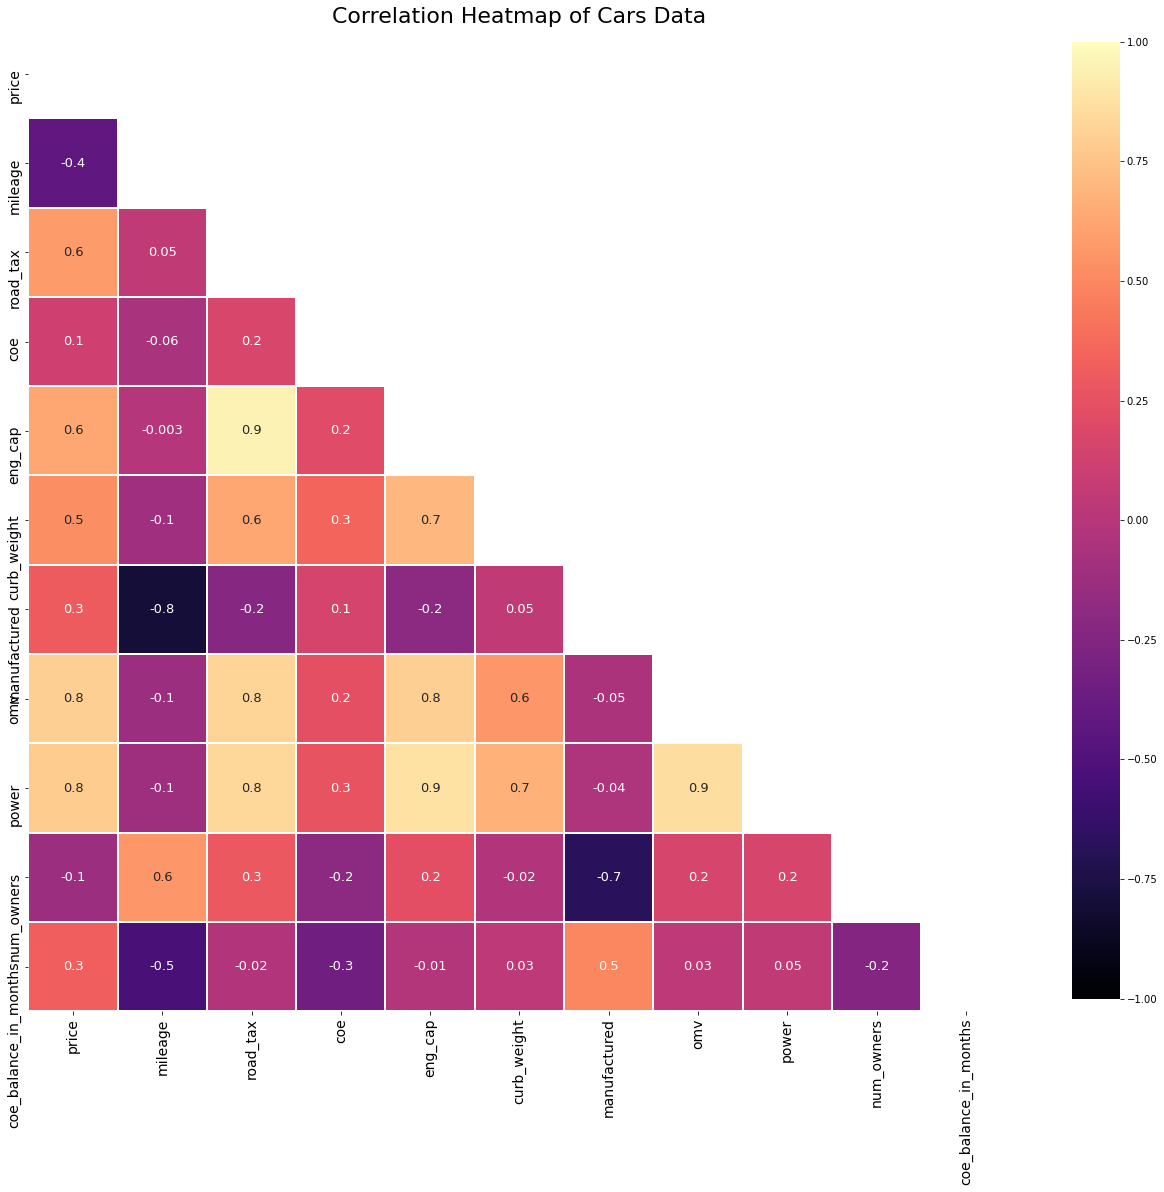

In [58]:
#instantiating correlation function for numerical features
heatmap(cars,'Correlation Heatmap of Cars Data')

From the correlation of the numeric features plotted above, we can already see that there exist some pairwise multicollinearity between features, as highlighted in the darker blue and red shades. These features may affect the performance of our model later. I will be dealing with these multicollinearity in the Feature Engineering portion of this notebook.

In [59]:
#creating scatter subplot function
def subplot_scatter(dataframe, list_of_x, y, list_of_titles):
    nrows = int(np.ceil(len(list_of_x)/2))
    fig, ax = plt.subplots(nrows=nrows, ncols=2,figsize=(20,40))
    ax = ax.ravel()
    for i, column in enumerate(list_of_x):
        ax[i].scatter(x=dataframe[list_of_x[i]],y=dataframe[y])
        ax[i].set_title(list_of_titles[i], fontsize=20,fontweight="bold")
        ax[i].set_xlabel('', fontsize=15)
        ax[i].set_ylabel(y, fontsize=15)
    ax.flat[-1].set_visible(False)
    plt.show();

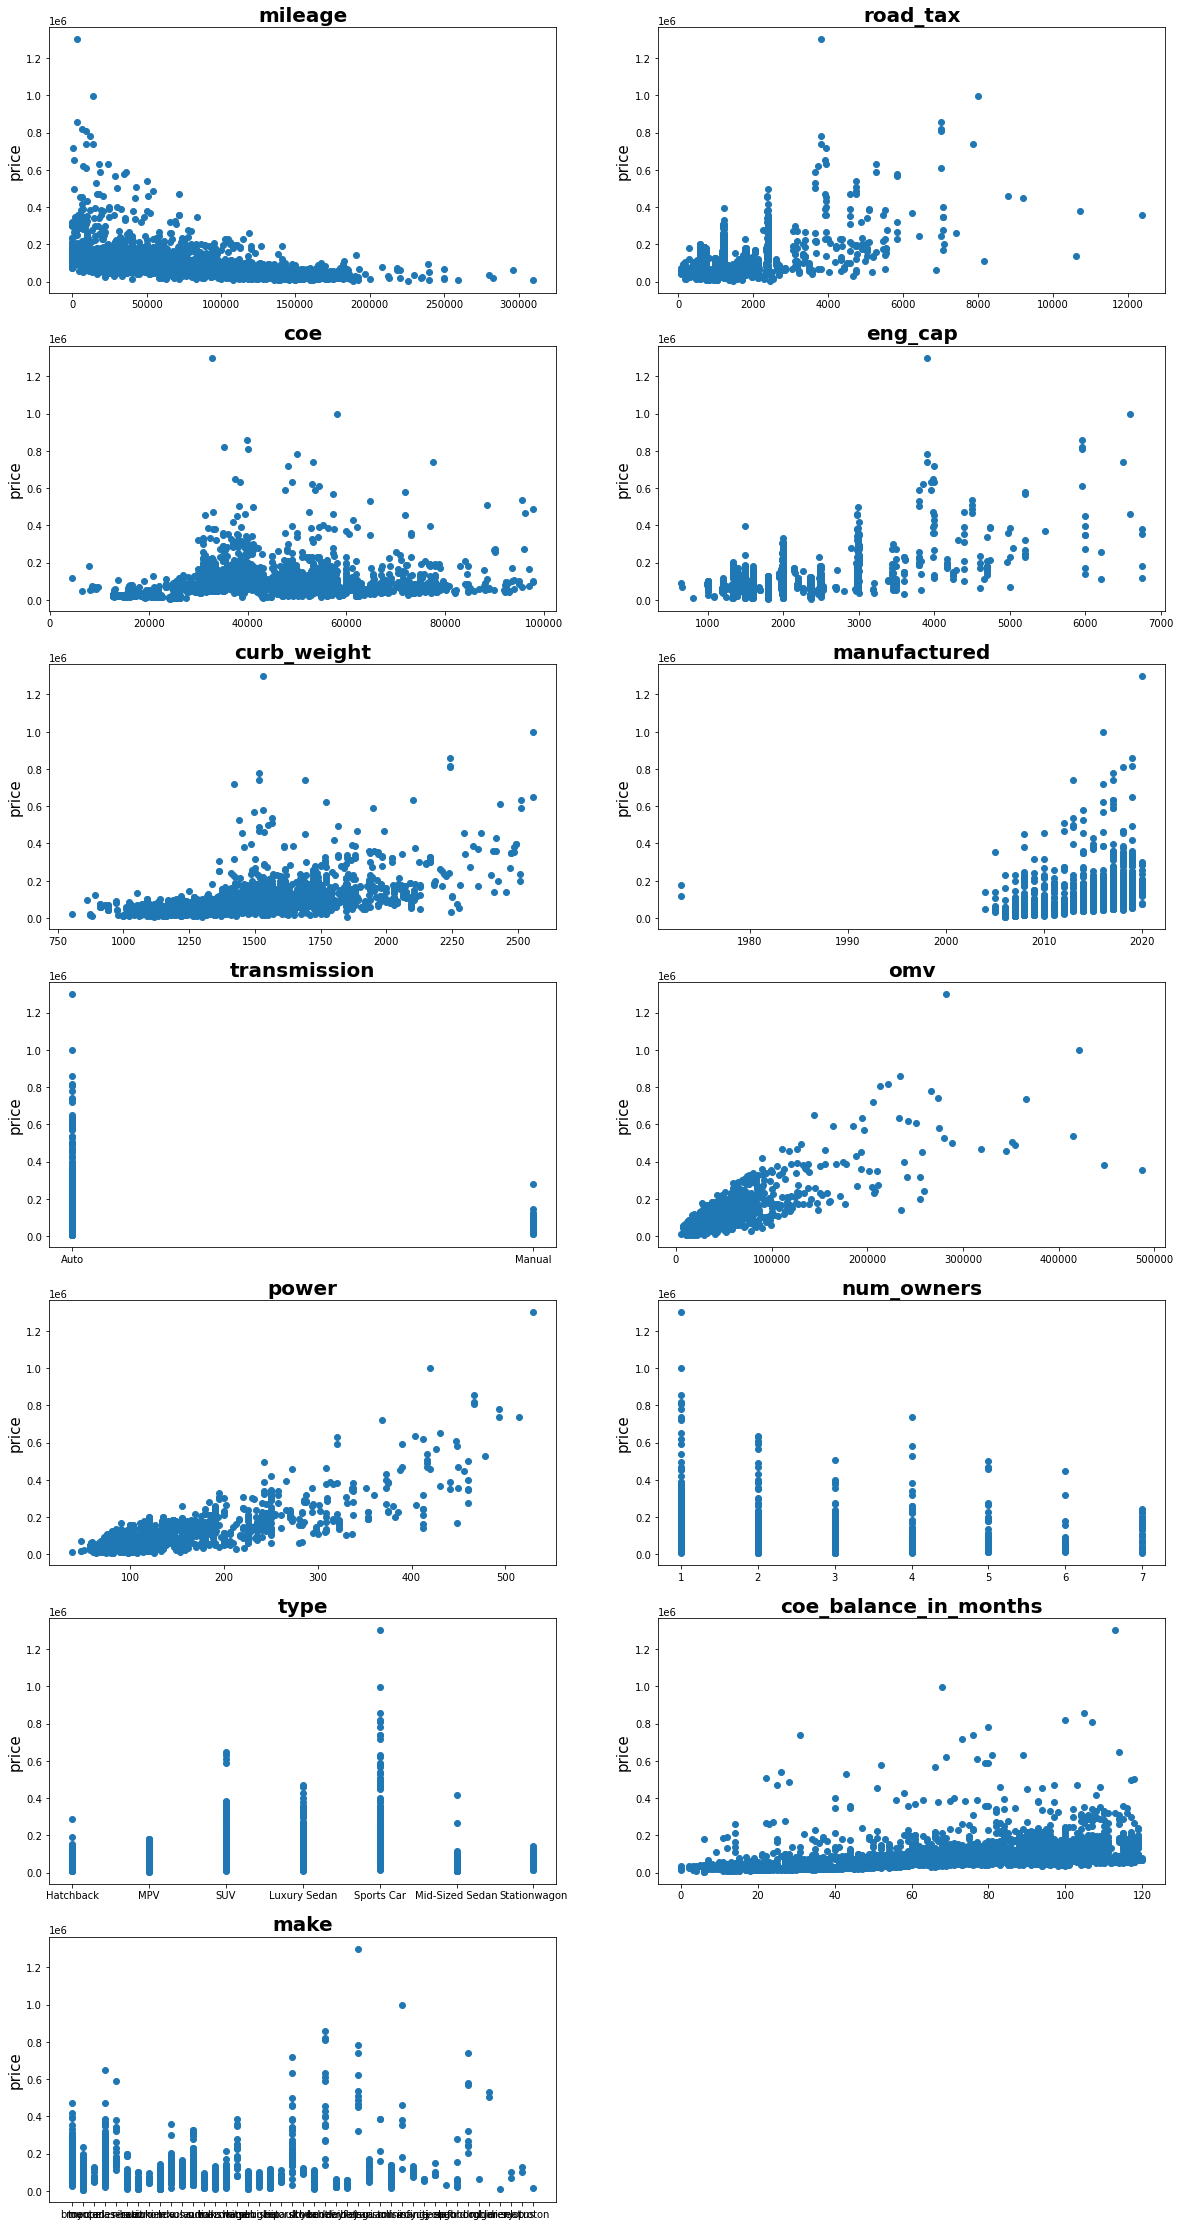

In [60]:
#instantiating subplot for features
subplot_scatter(cars, cars.drop(columns=['price','category']).columns, 'price',
                cars.drop(columns=['price','category']).columns);

The scatter subplots above shows the spread of the observations for each feature with respect to price.

Immediately we can see a peculiar distribution for the `manufactured` feature. Let's see the outliers for this feature.

In [61]:
#checking for manufactured outliers
cars[cars['manufactured'] < 2000]

,price,mileage,road_tax,coe,eng_cap,curb_weight,manufactured,transmission,omv,power,num_owners,type,category,coe_balance_in_months,make
512,179000,58500,280,7851,6750,2280,1973,Auto,27703,149,6,Luxury Sedan,"ImportedUsedVehicle,COECar,Rare&Exotic,LowMile...",34,rolls-royce
4415,118800,75000,280,4500,6750,2118,1973,Auto,18553,147,1,Luxury Sedan,"COECar,Rare&Exotic",87,rolls-royce


Since there are only 2 car listings that are before the year 2000, let's drop these observations so as it would not affect our model.

In [62]:
#dropping the manufactured outlier
cars.drop(index=cars[cars['manufactured'] < 2000].index,inplace=True)

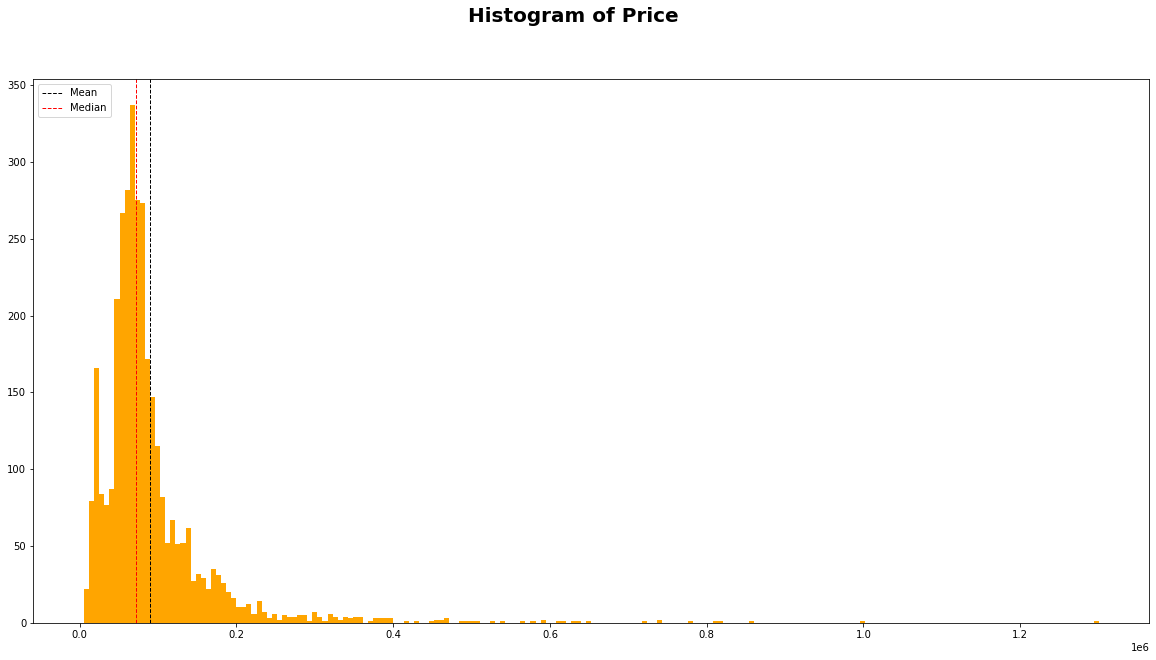

In [63]:
#plotting histogram for price
plt.figure(figsize=(20,10))
plt.suptitle('Histogram of Price', fontsize=20,fontweight="bold")
plt.axvline(cars['price'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(cars['price'].median(), color='k', linestyle='dashed', linewidth=1, c='red')
plt.hist(cars['price'],bins=200,color='orange')
min_ylim, max_ylim = plt.ylim()
plt.legend({'Mean':cars['price'].mean(),'Median':cars['price'].median()},loc='upper left');

The distribution is highly postively-skewed. This is something that we may need to address as it would mean that our train data would be high in bias.

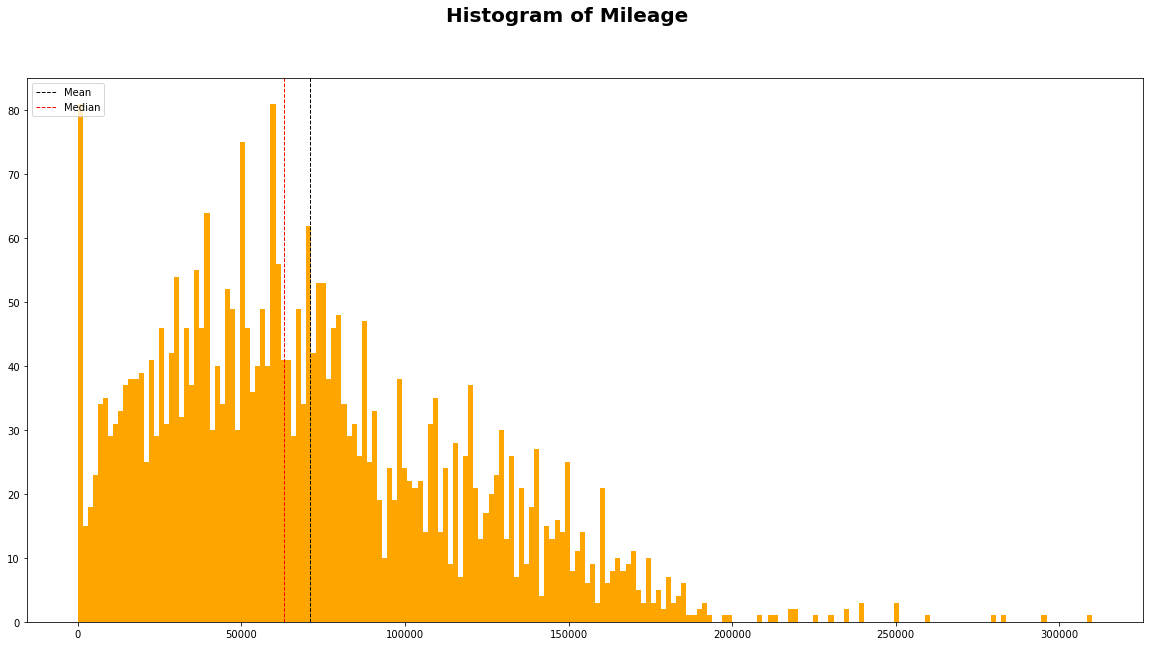

In [64]:
#plotting histogram of mileage
plt.figure(figsize=(20,10))
plt.suptitle('Histogram of Mileage', fontsize=20,fontweight="bold")
plt.axvline(cars['mileage'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(cars['mileage'].median(), color='k', linestyle='dashed', linewidth=1, c='red')
plt.hist(cars['mileage'],bins=200,color='orange')
min_ylim, max_ylim = plt.ylim()
plt.legend({'Mean':cars['mileage'].mean(),'Median':cars['mileage'].median()},loc='upper left');

Similar to the distribution of `price`, `mileage` distribution is highly postively-skewed and is something that we may need to address as it would mean that our train data would be high in bias.

In [65]:
#checking the value count of the car make
cars['make'].value_counts()

toyota           571
honda            465
mercedes-benz    420
bmw              351
volkswagen       187
audi             175
mazda            166
hyundai          159
nissan           124
kia              105
mitsubishi        92
lexus             73
volvo             66
subaru            56
porsche           44
suzuki            42
mini              31
citroen           24
maserati          23
peugeot           22
land              22
jaguar            20
opel              19
chevrolet         18
bentley           17
renault           11
ferrari           10
lamborghini        8
skoda              8
infiniti           7
ford               7
daihatsu           7
jeep               6
rolls-royce        4
aston              4
ssangyong          4
lotus              2
mclaren            2
seat               2
dodge              1
saab               1
chery              1
proton             1
Name: make, dtype: int64

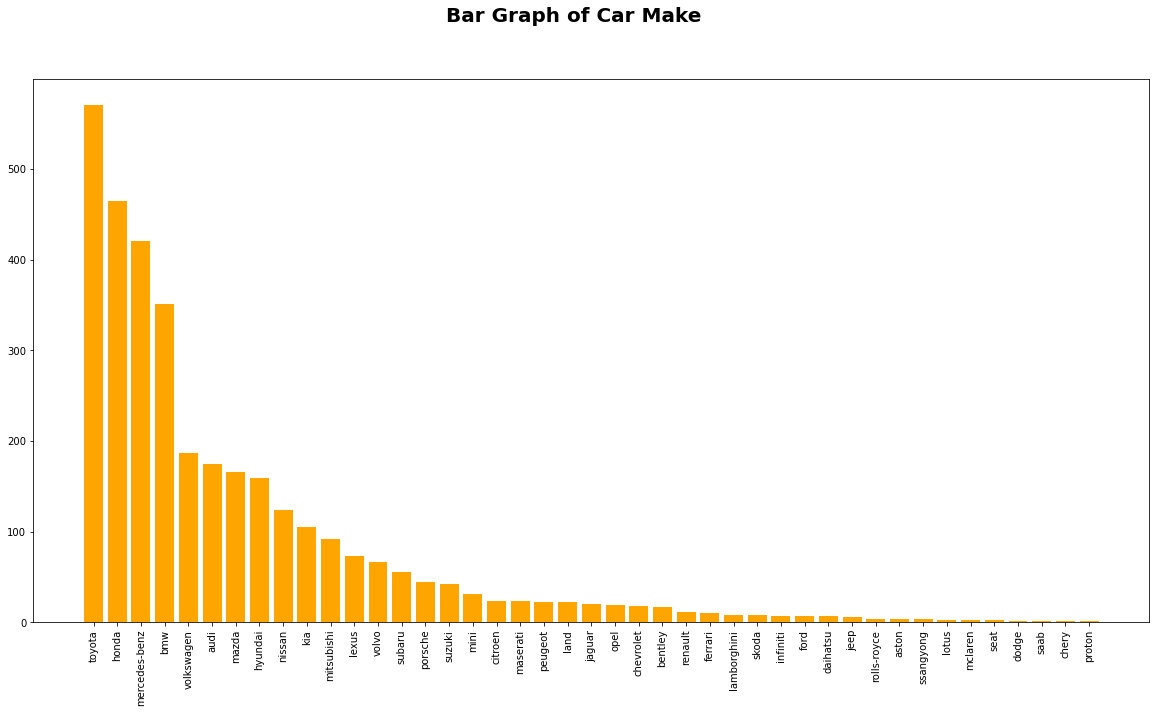

In [66]:
#plotting bar graph of the makes
plt.figure(figsize=(20,10))
plt.xticks(rotation='vertical')
plt.suptitle('Bar Graph of Car Make', fontsize=20,fontweight="bold")
plt.bar(cars['make'].value_counts().index,cars['make'].value_counts().values,color='orange');

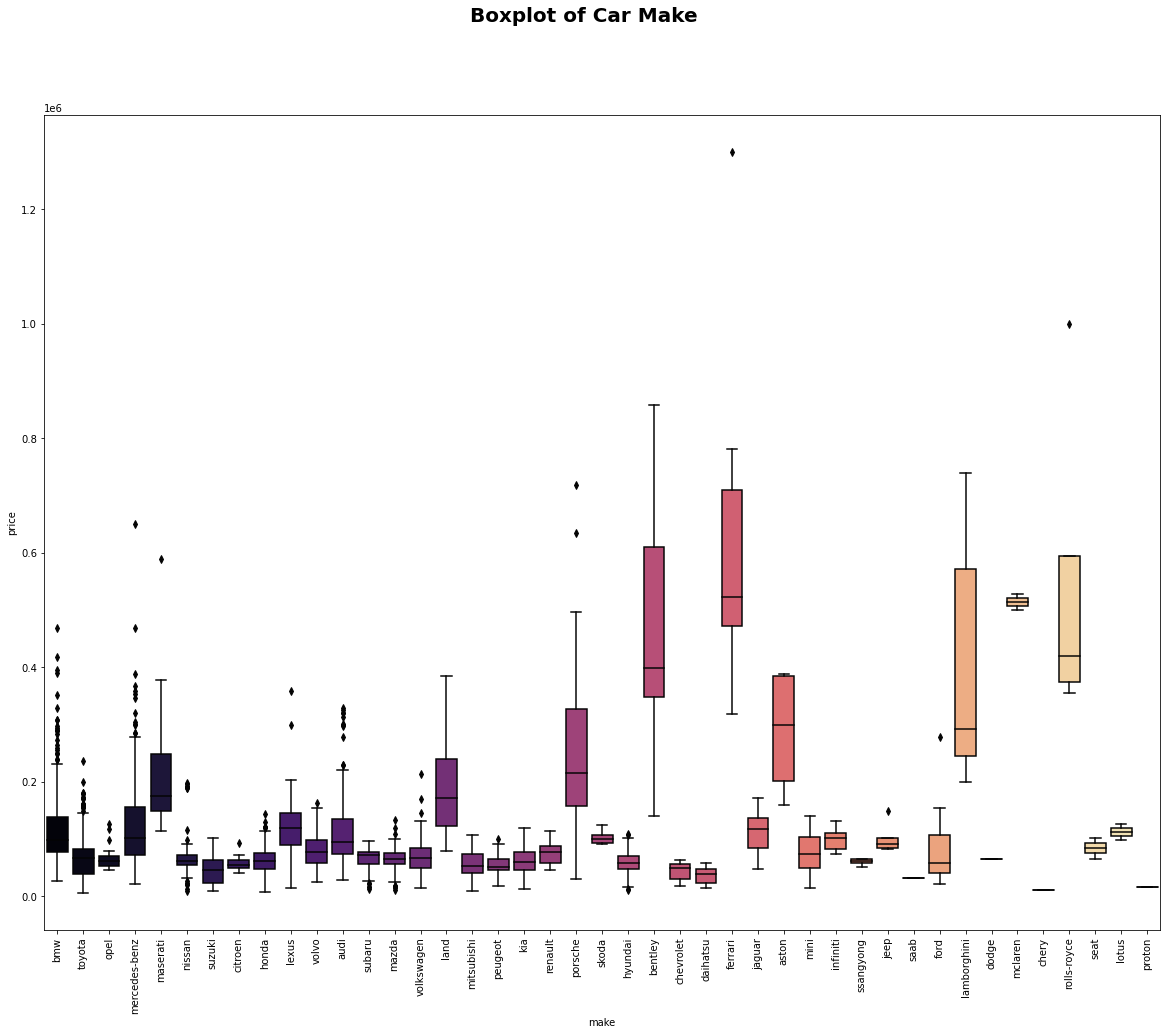

In [67]:
#plotting boxplot for makes
plt.figure(figsize=(20,15))
plt.suptitle('Boxplot of Car Make', fontsize=20,fontweight="bold")
plt.xticks(rotation='vertical')
sns.boxplot(y='price', x='make', data=cars, palette='magma');

The `make` of cars are concentrated towards the few brands, from `toyota` to `suzuki`. Let's map the rest as `other_makes` and see the distribution with respect to price.

In [68]:
#mapping the other brands together
others_list = ['mini','citroen','peugeot','opel','jaguar', 'saab',
               'porsche','maserati','chevrolet','land', 'mclaren',
               'renault','skoda','ford','infiniti','jeep', 'lamborghini',
               'daihatsu','seat','ssangyong','bentley','lotus', 'ferrari',
               'rolls-royce','dodge','aston','chery','proton']

for i in others_list:
    cars['make'] = cars['make'].str.replace(i,"other_makes")

As we can see from the above, the majority of the car makes are within within 0 - 150000. The `other_makes` makes up for the right tail end of the price. This may be due to luxury brands that pushes the price of car very very high.

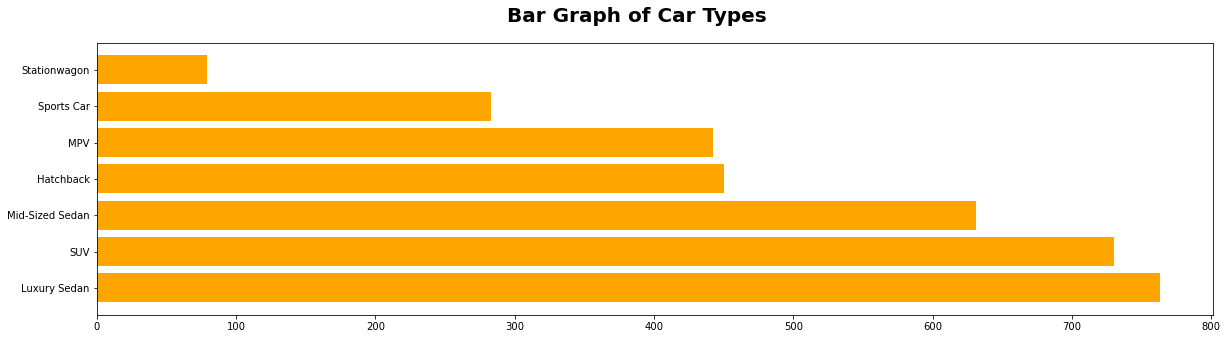

In [69]:
#plotting bar graph of car types
plt.figure(figsize=(20,5))
plt.suptitle('Bar Graph of Car Types', fontsize=20,fontweight="bold")
plt.barh(cars['type'].value_counts().index,cars['type'].value_counts().values,color='orange');

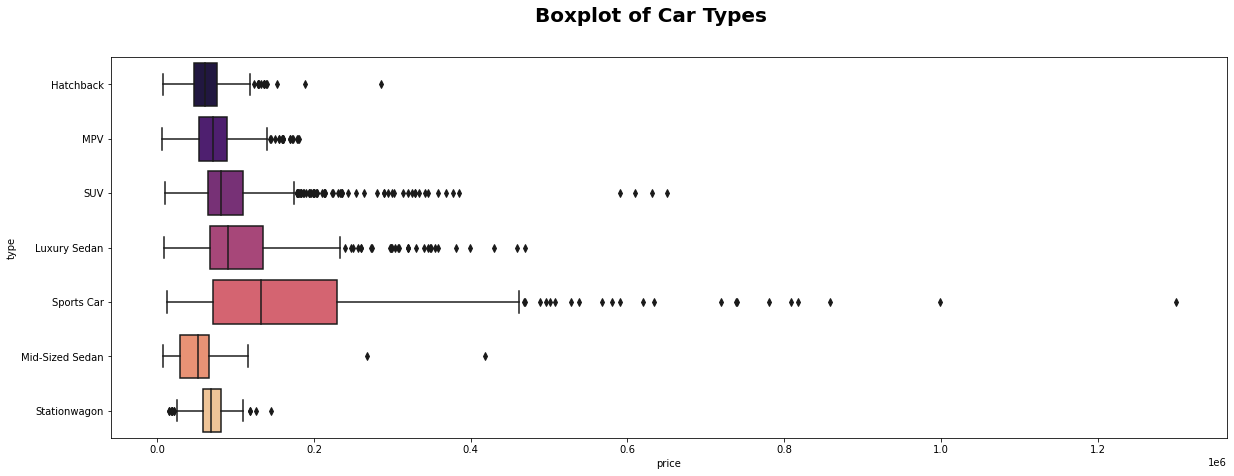

In [70]:
#plotting boxplot of car types
plt.figure(figsize=(20,7))
plt.suptitle('Boxplot of Car Types', fontsize=20,fontweight="bold")
sns.boxplot(y='type', x='price', data=cars,palette='magma');

The count of the types of vehicles are well distributed except for the `Stationwagon` and `Sports Car`. Let's combine them together to have a better distribution of car types.

In [71]:
#mapping the types together
others_list = ['Stationwagon','Sports Car']

for i in others_list:
    cars['type'] = cars['type'].str.replace(i,"other_type")

The boxplot of the car types again highlights the skewness of the price. The high prices of `other_types` may probably have been caused by the `Sports Car` that are naturally very high in price.

In [72]:
#splitting the categories and creating a dummy variable in another dataframe
categories = cars['category'].str.get_dummies(',')
merge = pd.concat([cars,categories], axis=1)
category_names = categories.columns

category_count = []
for i in category_names:
    category_count.append(cars.category.str.count(i).sum())
    
cat_df = pd.DataFrame()
cat_df['cat'] = category_names
cat_df['count'] = category_count
cat_df.sort_values(by='count',ascending=False,inplace=True)

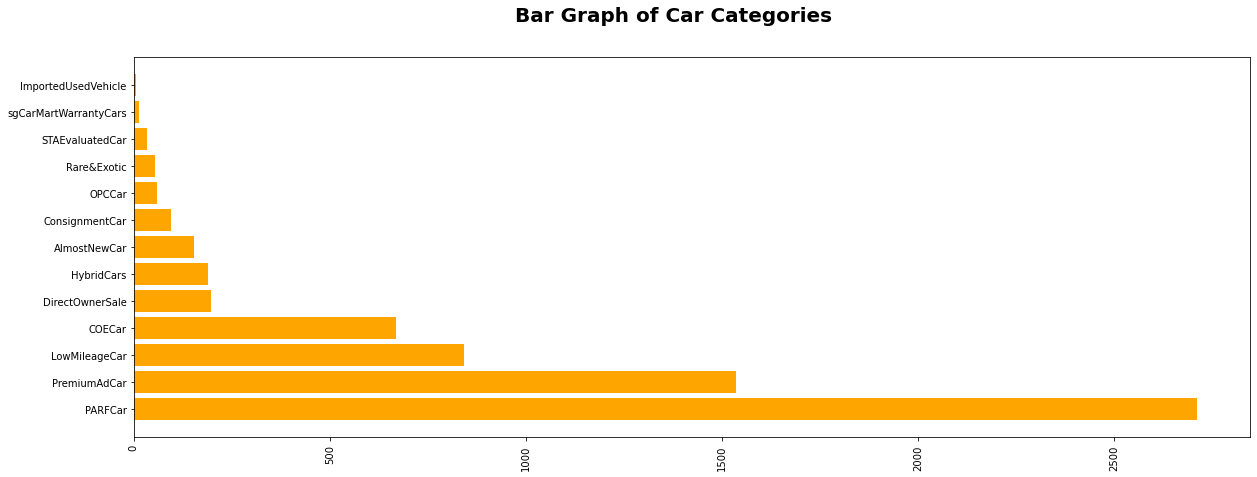

In [73]:
#plotting bar graph of the categories
plt.figure(figsize=(20,7))
plt.xticks(rotation='vertical')
plt.suptitle('Bar Graph of Car Categories', fontsize=20,fontweight="bold")
plt.barh(cat_df['cat'],cat_df['count'],color='orange');

The concentration of the cars belong to `COECar`, `LowMileageCar`, `PremiumAdCar` and `PARFCar`. 

Some of the listings belong to categories that is applicable to the listing services such as `PremiumAdCar`, I will be dropping them as they are not categories that a car owner will be able to know or have.

Also, since the number of `HybridCars`,`OPCCar` and `AlmostNewCar` are not large, I will group them together.

In [74]:
#mapping the features together and reinstantiating the dummy variable
others_list = ['HybridCars','OPCCar','AlmostNewCar']

for i in others_list:
    cars['category'] = cars['category'].str.replace(i,"other_cat")

categories = cars['category'].str.get_dummies(',')
merge = pd.concat([cars,categories], axis=1)
category_names = categories.columns

category_count = []
for i in category_names:
    category_count.append(cars.category.str.count(i).sum())
    
cat_df = pd.DataFrame()
cat_df['cat'] = category_names
cat_df['count'] = category_count
cat_df.sort_values(by='count',ascending=False,inplace=True)

In [75]:
#dropping the non-related categories
categories.drop(columns=['STAEvaluatedCar','sgCarMartWarrantyCars','ConsignmentCar','DirectOwnerSale',
                         'PremiumAdCar','Rare&Exotic','ImportedUsedVehicle','LowMileageCar'],inplace=True)

In [76]:
categories.columns

Index(['COECar', 'PARFCar', 'other_cat'], dtype='object')

In [77]:
#merging the categories with the cars dataframe
merge = pd.concat([cars,categories], axis=1)

In [78]:
#encoding transmission; Auto:1 Manual:0
merge['transmission'] = merge['transmission'].str.get_dummies()

In [79]:
#creating dummy variable for other object features
make = merge['make'].str.get_dummies()
type = merge['type'].str.get_dummies()

#merging all together
merge = pd.concat([merge,make], axis=1)
merge = pd.concat([merge,type], axis=1)

In [80]:
#dropping the pre-encoded features
merge.drop(columns=['type','category','make'],inplace=True)

In [81]:
#checking for merge dataframe
merge

,price,mileage,road_tax,coe,eng_cap,curb_weight,manufactured,transmission,omv,power,num_owners,coe_balance_in_months,COECar,PARFCar,other_cat,audi,bmw,honda,hyundai,kia,lexus,mazda,mercedes-benz,mitsubishi,nissan,other_makes,subaru,suzuki,toyota,volkswagen,volvo,Hatchback,Luxury Sedan,MPV,Mid-Sized Sedan,SUV,other_type
0,77800,76600,1082,44002,1496,1350,2017,1,25894,85,1,79,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,15500,172000,1361,25084,1794,1300,2007,1,16527,97,3,22,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
5,59800,43000,626,51109,1399,1233,2016,1,19839,110,2,72,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
6,83888,60540,1196,50089,1986,1610,2016,1,30993,111,1,63,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
8,82800,70000,1082,46778,1496,1395,2017,1,28674,85,1,80,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,65800,81928,684,51506,1498,1450,2016,1,22879,90,1,69,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4994,35800,99000,752,18238,1497,1115,2008,1,23778,88,3,59,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4995,23000,160000,821,12864,1497,1110,2009,1,13472,80,3,38,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4996,104800,52339,740,30209,1595,1395,2016,1,22609,90,1,93,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


# Feature Engineering

From what we saw in the previous section, we can already see that pairwise multi-collinearity exists between the features. Let's take a look once more and deal with this.

In [82]:
#getting the correlation of features with respect to price
feature_correlation = merge.corr()
feature_correlation[feature_correlation.index == 'price']

,price,mileage,road_tax,coe,eng_cap,curb_weight,manufactured,transmission,omv,power,num_owners,coe_balance_in_months,COECar,PARFCar,other_cat,audi,bmw,honda,hyundai,kia,lexus,mazda,mercedes-benz,mitsubishi,nissan,other_makes,subaru,suzuki,toyota,volkswagen,volvo,Hatchback,Luxury Sedan,MPV,Mid-Sized Sedan,SUV,other_type
price,1.0,-0.421189,0.584662,0.120387,0.631333,0.524936,0.32398,0.023296,0.804732,0.781307,-0.11953,0.321243,-0.238009,0.238009,0.152578,0.066628,0.125393,-0.155568,-0.098454,-0.072926,0.059786,-0.071478,0.140915,-0.075926,-0.057161,0.331879,-0.040849,-0.062125,-0.137091,-0.067278,-0.01221,-0.138225,0.115171,-0.087574,-0.240822,0.061936,0.312657


In [83]:
#setting the cut_off of these features and put them in a table.
cut_off = 0.7
high_corrs = feature_correlation[feature_correlation.abs() > cut_off][feature_correlation.abs() != 1].unstack().dropna().to_dict()
high_corrs = pd.Series(high_corrs, index = high_corrs.keys())
high_corrs = high_corrs.reset_index()
high_corrs = pd.DataFrame(high_corrs)
high_corrs.columns = ['Feature1', 'Feature 2','Correlations']
high_corrs['Correlations'] = high_corrs['Correlations'].drop_duplicates(keep ='first')
high_corrs = high_corrs.dropna().sort_values(by = 'Correlations', ascending = False)
high_corrs

,Feature1,Feature 2,Correlations
3,road_tax,eng_cap,0.965313
8,eng_cap,power,0.889789
15,omv,power,0.860317
11,manufactured,PARFCar,0.853554
5,road_tax,power,0.844195
4,road_tax,omv,0.822201
7,eng_cap,omv,0.812115
0,price,omv,0.804732
1,price,power,0.781307
2,mileage,manufactured,-0.825726


From the above table, there are some prominent features that has a high Pairwise Multi-Collinearity, such as `road_tax`, `eng_cap`, `power` and `omv`. I will be dropping the features that has a lower correlation to price.

In [84]:
#dropping the features
merge.drop(columns=['road_tax','eng_cap','power'],inplace=True)

In [85]:
#checking the multi-collinearity once more
feature_correlation = merge.corr()
cut_off = 0.7
high_corrs = feature_correlation[feature_correlation.abs() > cut_off][feature_correlation.abs() != 1].unstack().dropna().to_dict()
high_corrs = pd.Series(high_corrs, index = high_corrs.keys())
high_corrs = high_corrs.reset_index()
high_corrs = pd.DataFrame(high_corrs)
high_corrs.columns = ['Feature1', 'Feature 2','Correlations']
high_corrs['Correlations'] = high_corrs['Correlations'].drop_duplicates(keep ='first')
high_corrs = high_corrs.dropna().sort_values(by = 'Correlations', ascending = False)
high_corrs

,Feature1,Feature 2,Correlations
4,manufactured,PARFCar,0.853554
0,price,omv,0.804732
1,mileage,manufactured,-0.825726
3,manufactured,COECar,-0.853554
7,COECar,PARFCar,-1.000000


Again, I will be dropping the feature with a lower correlation to price.

In [86]:
#dropping feature
merge.drop(columns=['manufactured'],inplace=True)

# Data Modelling

In [87]:
#impporting packages for modelling
import scipy.stats as stats

from scipy.stats import pearsonr
from sklearn.linear_model import Lasso, LinearRegression, LassoCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [88]:
#setting target variables and features for our model
X = merge.drop(columns=['price'])
y = merge['price']

In [89]:
#splitting dataset between train and test
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33, random_state=42)

## Linear Regression

In [90]:
#instantiating our Linear Regression model
lr = LinearRegression()
lr.fit(Xtrain,ytrain)

LinearRegression()

In [91]:
print('Linear Model')

#adjusted r2

#Train R2 score
lr_train_r2 = lr.score(Xtrain,ytrain)
print('Train R^2 Score: {}'.format(lr_train_r2.round(4)))

#Test R2 score
lr_test_r2 = lr.score(Xtest,ytest)
print('Test R^2 Score: {}'.format(lr_test_r2.round(4)))

#Cross Validated R2 Score
lr_cross_val_r2 = cross_val_score(lr, Xtrain, ytrain, cv=5).mean()
print('Cross Validated Train R^2 Score: {}'.format(lr_cross_val_r2.round(4)))

#RMSE
lr_pred = lr.predict(Xtest)
lr_rmse = np.sqrt(mean_squared_error(ytest,lr_pred))
print('RMSE: {}'.format(lr_rmse))

Linear Model
Train R^2 Score: 0.8066
Test R^2 Score: 0.8168
Cross Validated Train R^2 Score: 0.8055
RMSE: 38464.21854059456


## Lasso Regression

In [92]:
#scaling the variables for lasso
ss = StandardScaler()

Xstrain = ss.fit_transform(Xtrain)
Xstest = ss.transform(Xtest)

In [93]:
#checking for optimal alpha
optimal_lasso = LassoCV(n_alphas=100, cv=10, verbose=1)
optimal_lasso.fit(Xstrain, ytrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(cv=10, verbose=1)

In [94]:
#instantiating Lasso Model
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso.fit(Xstrain, ytrain)

Lasso(alpha=57.647449386940515)

In [95]:
print('Lasso Model')

#Train R2 score
lasso_train_r2 = lasso.score(Xstrain,ytrain)
print('Train R^2 Score: {}'.format(lr_train_r2.round(4)))

#Test R2 score
lasso_test_r2 = lasso.score(Xstest,ytest)
print('Test R^2 Score: {}'.format(lasso_test_r2.round(4)))

#Cross Validated R2 Score
lasso_cross_val_r2 = cross_val_score(lasso, Xstrain, ytrain, cv=5).mean()
print('Cross Validated Train R^2 Score: {}'.format(lasso_cross_val_r2.round(4)))

#RMSE
lasso_pred = lasso.predict(Xstest)
lasso_rmse = np.sqrt(mean_squared_error(ytest,lasso_pred))
print('RMSE: {}'.format(lasso_rmse))

Lasso Model
Train R^2 Score: 0.8066
Test R^2 Score: 0.8168
Cross Validated Train R^2 Score: 0.8057
RMSE: 38470.45622104098


## Support Vector Regression

In [96]:
#setting parameters for grid search
param = {'kernel' : ('linear', 'poly'),
         'C' : [10,15,20],
         'degree' : [1,2,3],
         'coef0' : [0.01,0.1,0.5],
         'gamma' : ('auto','scale')}

svr = SVR()

gs = GridSearchCV(svr,param,cv=5,n_jobs=-1,verbose=2)

In [97]:
#instantiating grid search and fitting train data
gs.fit(Xstrain,ytrain)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   17.5s finished


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [10, 15, 20], 'coef0': [0.01, 0.1, 0.5],
                         'degree': [1, 2, 3], 'gamma': ('auto', 'scale'),
                         'kernel': ('linear', 'poly')},
             verbose=2)

In [98]:
#checking best parameters
gs.best_params_

{'C': 20, 'coef0': 0.01, 'degree': 1, 'gamma': 'auto', 'kernel': 'linear'}

In [99]:
print('SVR Model')

#Train R2 score
svr_train_r2 = gs.best_estimator_.score(Xstrain,ytrain)
print('Train R^2 Score: {}'.format(svr_train_r2.round(4)))

#Test R2 score
svr_test_r2 = gs.best_estimator_.score(Xstest,ytest)
print('Test R^2 Score: {}'.format(svr_test_r2.round(4)))

#Cross Validated R2 Score
svr_cross_val_r2 = cross_val_score(gs.best_estimator_, Xstrain, ytrain, cv=5).mean()
print('Cross Validated Train R^2 Score: {}'.format(svr_cross_val_r2.round(4)))

#RMSE
svr_pred = gs.best_estimator_.predict(Xstest)
svr_rmse = np.sqrt(mean_squared_error(ytest,svr_pred))
print('RMSE: {}'.format(svr_rmse))

SVR Model
Train R^2 Score: 0.4926
Test R^2 Score: 0.4348
Cross Validated Train R^2 Score: 0.4635
RMSE: 67568.79093338706


## Gradient Boost Regressor

In [100]:
#setting parameters for grid search
param = {'loss' : ['huber'],
         'n_estimators' : [1000,1500,2000],
         'max_depth' : [5,6,7,8,9,10]}

gboost = GradientBoostingRegressor()

gsboost = GridSearchCV(gboost,param,cv=5,n_jobs=-1,verbose=2)

In [101]:
#instantiating grid search and fitting train data
gsboost.fit(Xtrain,ytrain)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.8min finished


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'loss': ['huber'], 'max_depth': [5, 6, 7, 8, 9, 10],
                         'n_estimators': [1000, 1500, 2000]},
             verbose=2)

In [102]:
#checking for best parameters
gsboost.best_params_

{'loss': 'huber', 'max_depth': 8, 'n_estimators': 1500}

In [103]:
print('Gradient Boost Model')

#Train R2 score
gboost_train_r2 = gsboost.best_estimator_.score(Xtrain,ytrain)
print('Train R^2 Score: {}'.format(gboost_train_r2.round(4)))

#Test R2 score
gboost_test_r2 = gsboost.best_estimator_.score(Xtest,ytest)
print('Test R^2 Score: {}'.format(gboost_test_r2.round(4)))

#Cross Validated R2 Score
gboost_cross_val_r2 = cross_val_score(gsboost.best_estimator_, Xtrain, ytrain, cv=5).mean()
print('Cross Validated Train R^2 Score: {}'.format(gboost_cross_val_r2.round(4)))

#RMSE
gboost_pred = gsboost.best_estimator_.predict(Xtest)
gboost_rmse = np.sqrt(mean_squared_error(ytest,gboost_pred))
print('RMSE: {}'.format(gboost_rmse))

Gradient Boost Model
Train R^2 Score: 1.0
Test R^2 Score: 0.8748
Cross Validated Train R^2 Score: 0.9145
RMSE: 31801.508793123052


## Random Forest Regressor

In [104]:
#setting parameters for grid search
param = {'n_estimators' : [1500,2000,2500],
         'max_depth' : [8,9,10],
         'random_state' : [42]}

rf = RandomForestRegressor()

rfgs = GridSearchCV(rf,param,cv=5,n_jobs=-1,verbose=2)

In [105]:
#instantiating grid search and fitting train data
rfgs.fit(Xtrain,ytrain)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.4min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [8, 9, 10],
                         'n_estimators': [1500, 2000, 2500],
                         'random_state': [42]},
             verbose=2)

In [106]:
#checking for best parameters
rfgs.best_params_

{'max_depth': 10, 'n_estimators': 2000, 'random_state': 42}

In [107]:
print('Random Forest Model')

#Train R2 score
rf_train_r2 = rfgs.best_estimator_.score(Xtrain,ytrain)
print('Train R^2 Score: {}'.format(rf_train_r2.round(4)))

#Test R2 score
rf_test_r2 = rfgs.best_estimator_.score(Xtest,ytest)
print('Test R^2 Score: {}'.format(rf_test_r2.round(4)))

#Cross Validated R2 Score
rf_cross_val_r2 = cross_val_score(rfgs.best_estimator_, Xtrain, ytrain, cv=5).mean()
print('Cross Validated Train R^2 Score: {}'.format(rf_cross_val_r2.round(4)))

#RMSE
rf_pred = rfgs.best_estimator_.predict(Xtest)
rf_rmse = np.sqrt(mean_squared_error(ytest,rf_pred))
print('RMSE: {}'.format(rf_rmse))

Random Forest Model
Train R^2 Score: 0.9854
Test R^2 Score: 0.9054
Cross Validated Train R^2 Score: 0.9134
RMSE: 27636.868969301813


From all the models we have fitted and ran, the **Gradient Boost Regressor** and **Random Forest Regressor** performed the best. Although both has a high train and test R score, the RMSE are high. Let's try and tune these two models in the next section.

# Model Tuning

We have seen that `price` and `mileage` are highly positively-skewed. Let's try and set a limit to 2 times the median and see if it will improve the performance of our model.

In [108]:
#checking the price limit
2*statistics.median(cars['price'])

143888.0

In [109]:
#setting limit of price
merge = merge[merge['price'] <= 143600]

In [110]:
#checking mileage limit
2*statistics.median(merge['mileage'])

136904

In [111]:
#setting limit of mileage
merge = merge[merge['mileage'] <= 138000]

## Gradient Boost Regressor

In [112]:
#setting new target and feature with limit
Xt = merge.drop(columns=['price'])
yt = merge['price']

In [113]:
#splitting into train and test data
Xt_train,Xt_test,yt_train,yt_test = train_test_split(Xt,yt,test_size=0.33, random_state=42)

In [114]:
#setting grid search parameters
param = {'loss' : ['huber'],
         'n_estimators' : [1000,1500,2000],
         'max_depth' : [5,6,7,8,9,10]}

gboost = GradientBoostingRegressor()

gsboost = GridSearchCV(gboost,param,cv=5,n_jobs=-1,verbose=2)

In [115]:
#instantiating grid search and fit data
gsboost.fit(Xt_train,yt_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.1min finished


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'loss': ['huber'], 'max_depth': [5, 6, 7, 8, 9, 10],
                         'n_estimators': [1000, 1500, 2000]},
             verbose=2)

In [116]:
#checking for best parameters
gsboost.best_params_

{'loss': 'huber', 'max_depth': 5, 'n_estimators': 2000}

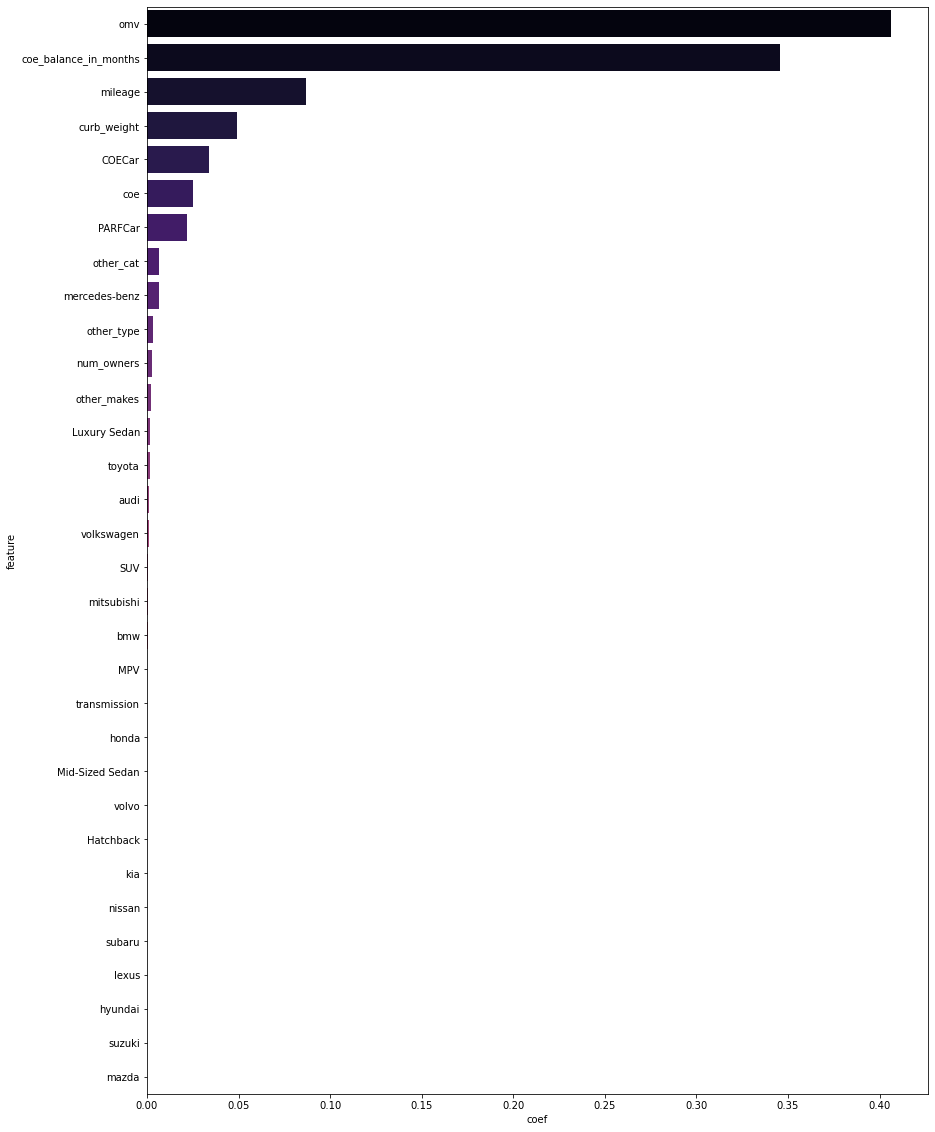

In [145]:
#plotting feature coefficient
features = [col for col in merge._get_numeric_data().columns if col !='price']
feature_gsboost_coef = pd.DataFrame({'feature':features,'coef':gsboost.best_estimator_.feature_importances_, 'abscoef' :np.abs(gsboost.best_estimator_.feature_importances_)})
feature_gsboost_coef.sort_values('abscoef', inplace=True, ascending=False)
plt.figure(figsize=(14,20))
sns.barplot(y='feature',x='coef', data=feature_gsboost_coef, palette='magma');

In [118]:
print('Tuned Gradient Boost Model')

#Train R2 score
gboost_train_r2 = gsboost.best_estimator_.score(Xt_train,yt_train)
print('Train R^2 Score: {}'.format(gboost_train_r2.round(4)))

#Test R2 score
gboost_test_r2 = gsboost.best_estimator_.score(Xt_test,yt_test)
print('Test R^2 Score: {}'.format(gboost_test_r2.round(4)))

#Cross Validated R2 Score
gboost_cross_val_r2 = cross_val_score(gsboost.best_estimator_, Xt_train, yt_train, cv=5).mean()
print('Cross Validated Train R^2 Score: {}'.format(gboost_cross_val_r2.round(4)))

#RMSE
gboost_pred = gsboost.best_estimator_.predict(Xt_test)
gboost_rmse = np.sqrt(mean_squared_error(yt_test,gboost_pred))
print('RMSE: {}'.format(gboost_rmse))

Tuned Gradient Boost Model
Train R^2 Score: 0.9999
Test R^2 Score: 0.9432
Cross Validated Train R^2 Score: 0.9287
RMSE: 6587.509517481801


## Random Forest Regressor

In [119]:
#setting grid search parameters
param = {'n_estimators' : [3000,3500],
         'max_depth' : [20,25],
         'random_state' : [42]}

rf = RandomForestRegressor()

rfgs = GridSearchCV(rf,param,cv=5,n_jobs=-1,verbose=2)

In [120]:
#instantiating grid search and fitting data
rfgs.fit(Xt_train,yt_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   40.4s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.2min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [20, 25], 'n_estimators': [3000, 3500],
                         'random_state': [42]},
             verbose=2)

In [121]:
#checking for best parameters
rfgs.best_params_

{'max_depth': 20, 'n_estimators': 3500, 'random_state': 42}

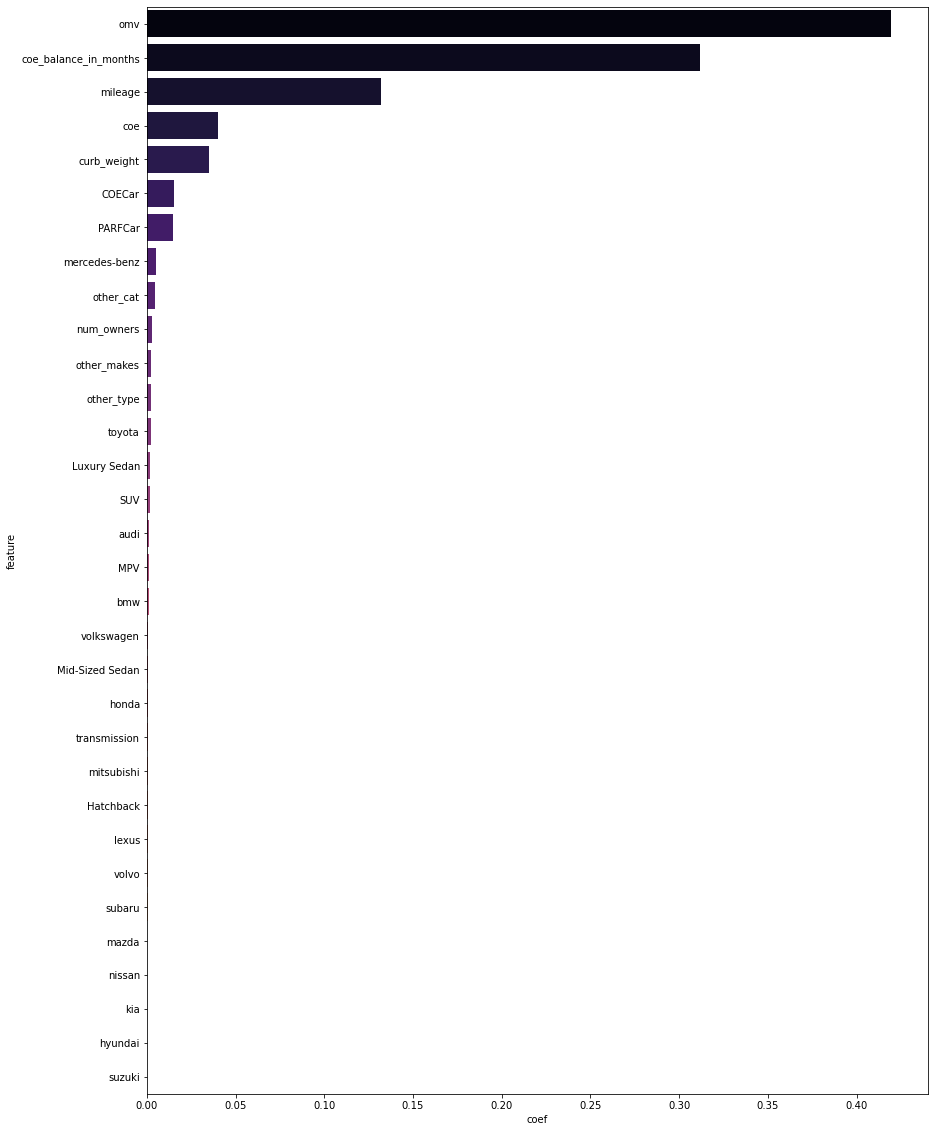

In [144]:
#plotting feature coefficients
features = [col for col in merge._get_numeric_data().columns if col !='price']
feature_rfgs_coef = pd.DataFrame({'feature':features,'coef':rfgs.best_estimator_.feature_importances_, 'abscoef' :np.abs(rfgs.best_estimator_.feature_importances_)})
feature_rfgs_coef.sort_values('abscoef', inplace=True, ascending=False)
plt.figure(figsize=(14,20))
sns.barplot(y='feature',x='coef', data=feature_rfgs_coef, palette='magma');

In [123]:
print('Tuned Random Forest Model')

#Train R2 score
rf_train_r2 = rfgs.best_estimator_.score(Xt_train,yt_train)
print('Train R^2 Score: {}'.format(rf_train_r2.round(4)))

#Test R2 score
rf_test_r2 = rfgs.best_estimator_.score(Xt_test,yt_test)
print('Test R^2 Score: {}'.format(rf_test_r2.round(4)))

#Cross Validated R2 Score
rf_cross_val_r2 = cross_val_score(rfgs.best_estimator_, Xt_train, yt_train, cv=5).mean()
print('Cross Validated Train R^2 Score: {}'.format(rf_cross_val_r2.round(4)))

#RMSE
rf_pred = rfgs.best_estimator_.predict(Xt_test)
rf_rmse = np.sqrt(mean_squared_error(yt_test,rf_pred))
print('RMSE: {}'.format(rf_rmse))

Tuned Random Forest Model
Train R^2 Score: 0.9895
Test R^2 Score: 0.9311
Cross Validated Train R^2 Score: 0.9135
RMSE: 7253.652807957996


We have managed to account for more observations and also reduce the error with our model tuning. We can see that the **Gradient Boost Regressor** performs better than the **Random Forest Regressor** with a higher test R^2 Score and a lower RMSE.

The feature importance between the two models are also similar, with only a few features ranking differently (such as `curb_weight` and `coe`). Both models are also heavily regularised and that proved to be the main factor in removing the bias and improving the error of the model. Ultimately, the difference in feature importance of the models made the difference, making the **Gradient Boost Regressor Model** the best one. Let's validate the model with a fresh set of data and see if it performs as well as our trained model.

# Model Validation

In [124]:
#converting csv into dataframe
car_val = pd.read_csv('../data/cars_info_validation.csv')

In [125]:
#checking dataframe
car_val

,model,link,price,depreciation,reg_date,mileage,road_tax,coe,eng_cap,curb_weight,manufactured,transmission,omv,power,num_owners,type,category
0,Toyota Wish 1.8A (COE till 12/2025),info.php?ID=960505&DL=1194,"$40,800","$8,250 /yr ...",27-Jan-2011(4yrs 11mths 9days COE left) ...,N.A. ...,\t$976 /yr,"$20,357","1,798 cc","1,360 kg ...",2010,Auto,"$21,503",106.0 kW (142 bhp),3,MPV,"Category\nCOE Car, Premium Ad Car"
1,Lexus ES250 Executive Sunroof,info.php?ID=929909&DL=2296,"$125,800","$14,550 /yrVie...",28-Mar-2018(7yrs 2mths 5days COE left) ...,"50,000...","\t$1,792 /yr","$37,010","2,494 cc","1,615 kg ...",2018,Auto,"$36,195",135.0 kW (181 bhp),1,Luxury Sedan,"Category\nPARF Car, Premium Ad Car"
2,Volvo V40 T2,info.php?ID=942028&DL=2296,"$78,500","$10,050 /yrVie...",16-Nov-2017(6yrs 9mths 24days COE left) ...,"51,000...",\t$684 /yr,"$47,112","1,498 cc","1,454 kg ...",2017,Auto,"$23,530",90.0 kW (120 bhp),1,Hatchback,"Category\nPARF Car, Premium Ad Car"
3,Opel Astra 1.0A Turbo,info.php?ID=955385&DL=2296,"$59,500","$8,460 /yrView...",17-Oct-2017(6yrs 8mths 24days COE left) ...,"62,000...",\t$392 /yr,"$41,761",999 cc,"1,188 kg ...",2017,Auto,"$19,155",77.0 kW (103 bhp),1,Hatchback,"Category\nPARF Car, Premium Ad Car"
4,Nissan Qashqai 2.0A Premium Moonroof,info.php?ID=944287&DL=3043,"$67,800","$9,770 /yrView...",28-Dec-2016(5yrs 11mths 5days COE left) ...,"75,200...","\t$1,210 /yr","$51,109","1,997 cc","1,379 kg ...",2016,Auto,"$19,653",106.0 kW (142 bhp),2,SUV,Category\nPARF Car
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,Mazda RX7 Efini (COE till 04/2029),info.php?ID=957241&DL=2051,"$328,000","$39,640 /yr ...",26-Apr-1993(8yrs 3mths 8days COE left) ...,"69,000...",\t$858 /yr,"$26,175","1,308 cc",N.A. ...,1992,Manual,"$52,183",More than 6,,Sports Car,"Category\nCOE Car, Low Mileage Car"
997,Hyundai Avante 1.6A GLS,info.php?ID=949870&DL=2855,"$78,800","$7,670 /yrView...",23-Jun-2020(9yrs 5mths COE left) ...,"1,000 ...",\t$738 /yr,"$31,210","1,591 cc","1,345 kg ...",2019,Auto,"$13,151",93.8 kW (125 bhp),1,Mid-Sized Sedan,"Category\nPARF Car, Almost New Car, Low Mileag..."
998,BMW 5 Series 528i Luxury,info.php?ID=961982&DL=2296,"$86,800","$17,360 /yrVie...",01-Apr-2014(3yrs 2mths 9days COE left) ...,"109,00...","\t$1,210 /yr","$84,001","1,997 cc","1,615 kg ...",2013,Auto,"$53,265",180.0 kW (241 bhp),2,Luxury Sedan,"Category\nPARF Car, Premium Ad Car"
999,Toyota C-HR Hybrid 1.8A G,info.php?ID=961981&DL=2425,"$75,888","$11,410 /yrVie...",08-Jun-2017(6yrs 4mths 16days COE left) ...,"32,101...",\t$974 /yr,"$54,556","1,797 cc","1,440 kg ...",2017,Auto,"$31,675",90.0 kW (120 bhp),1,SUV,"Category\nPARF Car, Premium Ad Car, Low Mileag..."


In [126]:
#checking for null values
car_val.isnull().sum()

model           0
link            0
price           1
depreciation    1
reg_date        1
mileage         1
road_tax        1
coe             1
eng_cap         1
curb_weight     1
manufactured    1
transmission    1
omv             1
power           1
num_owners      1
type            1
category        1
dtype: int64

In [127]:
#checking for the null
car_val[car_val['transmission'].isnull()]

,model,link,price,depreciation,reg_date,mileage,road_tax,coe,eng_cap,curb_weight,manufactured,transmission,omv,power,num_owners,type,category
100,Expired ads,listing_expired.php,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
#dropping null value
car_val.drop(index=100,inplace=True)

#dropping unused columns
car_val.drop(columns=['depreciation','link'],inplace=True)

In [129]:
#dropping wrongly scraped data
for i in car_val.columns:
    car_val.drop(index=car_val[car_val[i].str.contains('N.A')].index,inplace=True)

In [130]:
#cleaning the data similar to train data
car_val = car_val[car_val['transmission'].str.contains('Manual') | car_val['transmission'].str.contains('Auto')]

car_val['price'] = car_val['price'].str.replace("$","")
car_val['price'] = car_val['price'].str.replace(",","")

car_val['curb_weight'] = car_val['curb_weight'].str.replace(",","")
car_val['curb_weight'] = car_val.curb_weight.str.extract('(\d+)')

car_val['eng_cap'] = car_val['eng_cap'].str.replace(",","")
car_val['eng_cap'] = car_val.eng_cap.str.extract('(\d+)')

car_val['coe'] = car_val['coe'].str.replace("$","")
car_val['coe'] = car_val['coe'].str.replace(",","")

car_val['years'] = car_val['reg_date'].str.findall('(\d+)yr').str[0]
car_val['months'] = car_val['reg_date'].str.findall('(\d+)mth').str[0]
car_val['years'].fillna(0,inplace=True)
car_val['months'].fillna(0,inplace=True)
car_val['years'] = car_val['years'].astype(int)
car_val['months'] = car_val['months'].astype(int)

car_val['coe_balance_in_months'] = car_val['years']*12 + car_val['months']
car_val.drop(columns=['years','months','reg_date'],inplace=True)

car_val['power'] = car_val['power'].str.replace(r"\(.*?\)","")
car_val['power'] = car_val.power.str.extract('(\d+)')

car_val['omv'] = car_val['omv'].str.replace("$","")
car_val['omv'] = car_val['omv'].str.replace(",","")

car_val['road_tax'] = car_val['road_tax'].str.replace("$","")
car_val['road_tax'] = car_val['road_tax'].str.replace(",","")
car_val['road_tax'] = car_val.road_tax.str.extract('(\d+)')

car_val['mileage'] = car_val['mileage'].str.replace(",","")
car_val['mileage'] = car_val.mileage.str.extract('(\d+)')

car_val['category'] = car_val['category'].str.replace("Category\n","")
car_val['category'] = car_val['category'].str.replace(" ","")

car_val['num_owners'] = car_val['num_owners'].str.replace("More than 6","7")

car_val['make'] = car_val['model'].str.split(' ').str[0]
car_val['make'] = car_val['make'].str.lower()

car_val.drop(columns='model',inplace=True)

<ipython-input-130-6d3d8bf8f5d9>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  car_val['price'] = car_val['price'].str.replace("$","")
<ipython-input-130-6d3d8bf8f5d9>:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  car_val['coe'] = car_val['coe'].str.replace("$","")
<ipython-input-130-6d3d8bf8f5d9>:26: FutureWarning: The default value of regex will change from True to False in a future version.
  car_val['power'] = car_val['power'].str.replace(r"\(.*?\)","")
<ipython-input-130-6d3d8bf8f5d9>:29: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal stri

In [131]:
#converting object type to integer
car_val['price'] = car_val['price'].astype(int)
car_val['mileage'] = car_val['mileage'].astype(int)
car_val['road_tax'] = car_val['road_tax'].astype(int)
car_val['coe'] = car_val['coe'].astype(int)
car_val['eng_cap'] = car_val['eng_cap'].astype(int)
car_val['curb_weight'] = car_val['curb_weight'].astype(int)
car_val['manufactured'] = car_val['manufactured'].astype(int)
car_val['omv'] = car_val['omv'].astype(int)
car_val['power'] = car_val['power'].astype(int)
car_val['num_owners'] = car_val['num_owners'].astype(int)

In [132]:
#impose limitation on validated data
car_val.drop(index=car_val[car_val['manufactured'] < 2000].index,inplace=True)
#remove features that are not in model
car_val.drop(columns=['road_tax','eng_cap','power','manufactured'],inplace=True)

In [133]:
#encoding in accordance to the train data
others_list = ['mini','citroen','peugeot','opel','jaguar', 'saab',
               'porsche','maserati','chevrolet','land', 'mclaren', 'alfa',
               'renault','skoda','ford','infiniti','jeep', 'lamborghini',
               'daihatsu','seat','ssangyong','bentley','lotus', 'ferrari',
               'rolls-royce','dodge','aston','chery','proton']
for i in others_list:
    car_val['make'] = car_val['make'].str.replace(i,"other_makes")

    
others_list = ['Stationwagon','Sports Car']
for i in others_list:
    car_val['type'] = car_val['type'].str.replace(i,"other_type")

    
others_list = ['HybridCars','OPCCar','AlmostNewCar']
for i in others_list:
    car_val['category'] = car_val['category'].str.replace(i,"other_cat")

categories_val = car_val['category'].str.get_dummies(',')
categories_val.drop(columns=['STAEvaluatedCar', 'ConsignmentCar', 'DirectOwnerSale', 'PremiumAdCar', 'LowMileageCar','ImportedUsedVehicle','Rare&Exotic'] ,inplace=True)
merge_val = pd.concat([car_val,categories_val], axis=1)

In [134]:
#merging the dataframes together
merge_val['transmission'] = merge_val['transmission'].str.get_dummies()

make = merge_val['make'].str.get_dummies()
type = merge_val['type'].str.get_dummies()

merge_val = pd.concat([merge_val,make], axis=1)
merge_val = pd.concat([merge_val,type], axis=1)

merge_val.drop(columns=['type','category','make'],inplace=True)

In [135]:
#checking shape
merge_val.shape

(785, 33)

In [136]:
#checking shape
merge.shape

(2636, 33)

In [137]:
#setting target and feature variables
X_val = merge_val.drop(columns='price')
y_val = merge_val['price']

In [138]:
merge_val.drop(index=merge_val[merge_val['price'] > 143600].index,inplace=True)
merge_val.drop(index=merge_val[merge_val['mileage'] > 138000].index,inplace=True)

In [139]:
#checking shape
merge_val.shape

(602, 33)

In [140]:
X_val_lim = merge_val.drop(columns='price')
y_val_lim = merge_val['price']

In [141]:
#checking validated score and error
print('Validated Gradient Boost Model')

#Validated R2 score
gboost_test_r2 = gsboost.best_estimator_.score(X_val,y_val)
print('Validated R^2 Score: {}'.format(gboost_test_r2.round(4)))

#Validated RMSE
gboost_pred = gsboost.best_estimator_.predict(X_val)
gboost_rmse = np.sqrt(mean_squared_error(y_val,gboost_pred))
print('Validated RMSE: {}'.format(gboost_rmse))

Validated Gradient Boost Model
Validated R^2 Score: 0.4717
Validated RMSE: 57260.981402754296


In [142]:
#checking validated score and error
print('Validated with Limit Gradient Boost Model')

#Validated R2 score
gboost_test_r2 = gsboost.best_estimator_.score(X_val_lim,y_val_lim)
print('Validated R^2 Score: {}'.format(gboost_test_r2.round(4)))

#Validated RMSE
gboost_pred = gsboost.best_estimator_.predict(X_val_lim)
gboost_rmse = np.sqrt(mean_squared_error(y_val_lim,gboost_pred))
print('Validated RMSE: {}'.format(gboost_rmse))

Validated with Limit Gradient Boost Model
Validated R^2 Score: 0.9223
Validated RMSE: 7528.850819595242


From the validation data, we can see that the R^2 Score has dropped slightly with the error increasing slightly as well.

The model is able to account for **92.11%** of the validation data with a prediction error of **$7589.52**, by limiting the `price` and `mileage`. 

In contrast, without limiting the two features, the model is only able to account for **44.1%** of the validation data with a prediction error of **$57,301.98**.

In [143]:
#saving model pickle
import pickle
filename = '../model/finalized_model.sav'
pickle.dump(gsboost.best_estimator_, open(filename, 'wb'))

# Conclusion

## Findings

- **Gradient Boost Regressor** performed the best for this project.
- Limiting the `price` and `mileage` of the dataset to a more normalised distribution increases the model performance significantly.
- `omv`,`coe_balance_in_months` and `mileage` are the strongest features in predicting car price.
- Model performs well with newly scraped data.
- Car make preference not solely reliant on price. BMW and Mercedes proved that price is not a turn off when it comes to buying cars.

## Limitations

Although the model is able to account for **92.11%** of the validation data with a prediction error of **$7589.52**, it was achieved by setting a few limits such as:

- Car price of $143,600 and below
- Car mileage of 138,00km and below
- Car manufactured year 2000 and later

## Further Research

- More data on cars above $143,600 may help improve the model further.
- More data on cars with mileage above 138,000km may also help improve the model further.
- Factors such as condition of car or involvement in accidents would be able to reduce more errors as these are important factors when selling a car. More data on this would help improve the model further.